In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
from PIL import Image, ImageEnhance
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
phsyical_devices = tf.config.experimental.list_physical_devices("GPU")# True/False
print("Num GPUs available : " , len(phsyical_devices))
tf.config.experimental.set_memory_growth(phsyical_devices[0], True)
print(tf.__version__)

Num GPUs available :  1
2.5.0


In [3]:
def plot_confusion_matrix(cm, classes,normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else :
        print("Confusion matrix without normalization")

    print(cm)

    thresh = cm.max() / 2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i,j], horizontalalignment="center", color="white" if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [4]:
premodel = tf.keras.applications.mobilenet.MobileNet()

In [5]:
premodel.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [6]:
output = premodel.layers[-7].output
output = Flatten()(output)
output = Dense(units=4, activation="softmax")(output)

In [7]:
model = Model(inputs=premodel.input, outputs=output)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [9]:
for layer in model.layers[:-2]:
    layer.trainable = False

In [10]:
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [11]:
train_path = "data/train"
valid_path = "data/valid"
test_path = "data/test"

In [12]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
                .flow_from_directory(directory=train_path, target_size=(224,224), batch_size=128)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
                .flow_from_directory(directory=valid_path, target_size=(224,224), batch_size=128)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
                .flow_from_directory(directory=test_path, target_size=(224,224), batch_size=128, shuffle=False)
                    

Found 3957 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


In [13]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=3, verbose=2, workers=16)

Epoch 1/5
31/31 - 168s - loss: 3.8845 - accuracy: 0.7488 - val_loss: 0.0845 - val_accuracy: 0.9875
Epoch 2/5
31/31 - 117s - loss: 0.0355 - accuracy: 0.9944 - val_loss: 0.0028 - val_accuracy: 0.9975
Epoch 3/5
31/31 - 128s - loss: 0.0012 - accuracy: 0.9995 - val_loss: 0.0057 - val_accuracy: 0.9975
Epoch 4/5


KeyboardInterrupt: 

In [21]:
# model.save("my_rabbit_classifier_mobilenet.h5")

In [14]:
test_labels = test_batches.classes

In [15]:
predictions = model.predict(x=test_batches, verbose=0)

In [16]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [17]:
test_batches.class_indices

{'andromeda': 0, 'merlin': 1, 'morgana': 2, 'perseus': 3}

Confusion matrix without normalization
[[25  5  0  0]
 [ 0 30  0  0]
 [ 0  0 30  0]
 [ 0  0  0 30]]


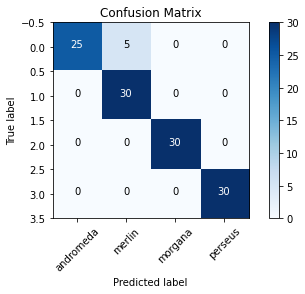

In [18]:
cm_plot_labels = ["andromeda","merlin","morgana","perseus"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")